In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, LabelBinarizer

%pylab inline
pd.options.mode.chained_assignment = None # чтобы странные варнинги не выдавал

Populating the interactive namespace from numpy and matplotlib


In [2]:
def rmsle(y_true,y_pred):
   assert len(y_true) == len(y_pred)
   return np.square(np.log(y_pred + 1) - np.log(y_true + 1)).mean() ** 0.5

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df = df.drop(['Id','Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], axis=1)

In [5]:
X = df.drop('SalePrice', axis=1)
y = df['SalePrice'].values

(0, 500000)

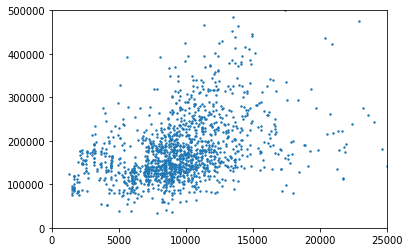

In [6]:
plt.scatter(X['LotArea'], y, s=2)
plt.xlim(0, 25000)
plt.ylim(0, 500000)

In [7]:
cont_features = X.select_dtypes(include=['int64', 'float64'])
for col in cont_features.columns:
    cont_features[col] = cont_features[col].fillna(cont_features[col].mean())

In [8]:
cat_features = X.select_dtypes(include=['object'])

In [9]:
le_for_feature = {}
cat_for_feature = {}

for col in cat_features.columns:
    cat_for_feature[col] = {}
    cat_for_feature[col]['unique'] = cat_features[col].unique()
    cat_for_feature[col]['most_frequent'] = cat_features[col].value_counts().idxmax()
    
    le = LabelEncoder()
    le.fit(cat_features[col].astype(str))
    cat_features[col] = le.transform(cat_features[col].astype(str))
    le_for_feature[col] = le

In [10]:
ohe = OneHotEncoder()
encoded_cat = pd.DataFrame(ohe.fit_transform(cat_features).toarray())

In [11]:
X = cont_features.join(encoded_cat)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [13]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print(mean_absolute_error(y_test, lr.predict(X_test)))
print(rmsle(y_test, lr.predict(X_test)))

17936.465641488227
0.20806362239114645


In [14]:
class myLinearRegression:
    def fit(self, X, y):
        self.W = np.dot(np.linalg.pinv(X), y)
    
    def predict(self, X_test):
        return np.dot(X_test, self.W)

In [15]:
my_lr = myLinearRegression()
my_lr.fit(X_train, y_train)
print(mean_absolute_error(y_test, my_lr.predict(X_test)))
print(rmsle(y_test, my_lr.predict(X_test)))

17951.966259384964
0.207960743173745


In [16]:
my_lr.fit(X, y)

In [17]:
data = pd.read_csv("test.csv")

In [18]:
ids = data['Id']
X_test = data[list(cat_features.columns) + list(cont_features.columns)]

In [19]:
print(X_test.shape, X.shape)

(1459, 74) (1460, 281)


In [20]:
cont_features_test = X_test.select_dtypes(include=['int64', 'float64'])
for col in cont_features_test.columns:
    cont_features_test[col] = cont_features_test[col].fillna(cont_features_test[col].mean())

In [21]:
cat_features_test = X_test.select_dtypes(include=['object'])
replace_dict = {}

for col in cat_features_test.columns:
    replace_dict[col] = dict.fromkeys(
        (set(cat_features_test[col].unique()) - set(cat_for_feature[col]['unique'])), 
        cat_for_feature[col]['most_frequent'])

In [22]:
cat_features_test.replace(replace_dict, inplace=True)

In [23]:
for col in cat_features_test.columns:
    cat_features_test[col] = le_for_feature[col].transform(cat_features_test[col].astype(str))

In [24]:
encoded_cat_test = pd.DataFrame(ohe.transform(cat_features_test).toarray())

X_test = cont_features_test.join(encoded_cat_test)

In [25]:
print(X_test.shape, X.shape)

(1459, 281) (1460, 281)


In [26]:
ans = pd.concat([ids, pd.DataFrame(my_lr.predict(X_test))+9000], axis=1)
print(ans)

        Id              0
0     1461  121751.715698
1     1462  169168.929063
2     1463  198385.773651
3     1464  205762.246668
4     1465  211132.261903
5     1466  181373.117307
6     1467  190472.739249
7     1468  167898.833180
8     1469  213370.349690
9     1470  124344.758337
10    1471  173410.150417
11    1472  105794.534769
12    1473  102458.188071
13    1474  153591.662823
14    1475  115122.371447
15    1476  385455.260815
16    1477  269193.976530
17    1478  320832.775152
18    1479  313695.677058
19    1480  489448.809107
20    1481  322066.676934
21    1482  213092.791414
22    1483  186765.535058
23    1484  169373.357473
24    1485  186515.148394
25    1486  198480.128449
26    1487  344366.893204
27    1488  228825.042097
28    1489  213203.015714
29    1490  267844.817481
...    ...            ...
1429  2890   88115.180029
1430  2891  165358.102558
1431  2892   17280.763194
1432  2893   82162.048053
1433  2894   17892.793850
1434  2895  357178.284066
1435  2896  

In [27]:
ans1 = ans.rename({ans.columns[1]: 'SalePrice'}, axis=1)

In [28]:
ans1.to_csv("submission.csv", index=False)